### Favorita 2016 10 weeks (28-06 to 31-08 : 65 days inclusive)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import datetime

PATH = 'data/favorita/'

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", PATH]).decode("utf8"))

# Any results you write to the current directory are saved as output.

holidays_events.csv
items.csv
models
oil.csv
sample_submission.csv
stores.csv
test.csv
tmp
train.csv
transactions.csv



## Create datasets

In [4]:
table_names = ['train', 'stores', 'items', 'transactions', 
               'holidays_events', 'oil', 'test', 'sample_submission']

We'll be using the popular data manipulation framework pandas. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list tables.

In [5]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [6]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* **train**: includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows

* **stores**: metadata; including city, state, type, and cluster; cluster is a grouping of similar stores

* **items**: metadata; including family, class, and perishable; perishable have a score weight of 1.25; otherwise, the weight is 1.0

* **transactions**: count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe

* **holidays_events**: metadata; Pay special attention to the transferred column.
    * A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.
    * For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

* **oil**: Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

* **test**: Test data, with the date, store_nbr, item_nbr combinations that are to be predicted, along with the onpromotion information.
    * NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.
    * The public / private leaderboard split is based on time. All items in the public split are also included in the private split.
    
* **sample_submission**: sample submission file in the correct format. It is highly recommend you zip your submission file before uploading!

In [7]:
for t in tables: display(t.head(), t.shape)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


(125497040, 6)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


(54, 5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


(4100, 4)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


(83488, 3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


(350, 6)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


(1218, 2)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


(3370464, 5)

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


(3370464, 2)

In [8]:
# The following returns summarized aggregate information to each table accross each field.
for t in tables: display(DataFrameSummary(t).summary())

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.25497e+08,NaN,1.25497e+08,1.25497e+08,1.25497e+08,NaN
mean,6.27485e+07,NaN,27.4646,972769,8.55487,NaN
std,3.62279e+07,NaN,16.3305,520534,23.6052,NaN
min,0,NaN,1,96995,-15372,NaN
25%,3.13743e+07,NaN,12,522383,2,NaN
50%,6.27485e+07,NaN,28,959500,4,NaN
75%,9.41228e+07,NaN,43,1.35438e+06,9,NaN
max,1.25497e+08,NaN,54,2.12711e+06,89440,NaN
counts,125497040,125497040,125497040,125497040,125497040,103839389
uniques,125497040,1684,54,4036,258474,2


,store_nbr,city,state,type,cluster
count,54,NaN,NaN,NaN,54
mean,27.5,NaN,NaN,NaN,8.48148
std,15.7321,NaN,NaN,NaN,4.69339
min,1,NaN,NaN,NaN,1
25%,14.25,NaN,NaN,NaN,4
50%,27.5,NaN,NaN,NaN,8.5
75%,40.75,NaN,NaN,NaN,13
max,54,NaN,NaN,NaN,17
counts,54,54,54,54,54
uniques,54,22,16,5,17


,item_nbr,family,class,perishable
count,4100,NaN,4100,4100
mean,1.25144e+06,NaN,2169.65,0.240488
std,587687,NaN,1484.91,0.427432
min,96995,NaN,1002,0
25%,818111,NaN,1068,0
50%,1.3062e+06,NaN,2004,0
75%,1.90492e+06,NaN,2990.5,0
max,2.13424e+06,NaN,7780,1
counts,4100,4100,4100,4100
uniques,4100,33,337,2


,date,store_nbr,transactions
count,NaN,83488,83488
mean,NaN,26.9392,1694.6
std,NaN,15.6082,963.287
min,NaN,1,5
25%,NaN,13,1046
50%,NaN,27,1393
75%,NaN,40,2079
max,NaN,54,8359
counts,83488,83488,83488
uniques,1682,54,4993


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
counts,350,350,350,350,350,350
uniques,312,6,3,24,103,2
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%
types,categorical,categorical,categorical,categorical,categorical,bool


,date,dcoilwtico
count,NaN,1175
mean,NaN,67.7144
std,NaN,25.6305
min,NaN,26.19
25%,NaN,46.405
50%,NaN,53.19
75%,NaN,95.66
max,NaN,110.62
counts,1218,1175
uniques,1218,998


,id,date,store_nbr,item_nbr,onpromotion
count,3.37046e+06,NaN,3.37046e+06,3.37046e+06,NaN
mean,1.27182e+08,NaN,27.5,1.2448e+06,NaN
std,972969,NaN,15.5858,589836,NaN
min,1.25497e+08,NaN,1,96995,NaN
25%,1.2634e+08,NaN,14,805321,NaN
50%,1.27182e+08,NaN,27.5,1.29466e+06,NaN
75%,1.28025e+08,NaN,41,1.73002e+06,NaN
max,1.28868e+08,NaN,54,2.13424e+06,NaN
counts,3370464,3370464,3370464,3370464,3370464
uniques,3370464,16,54,3901,2


,id,unit_sales
count,3.37046e+06,3.37046e+06
mean,1.27182e+08,0
std,972969,0
min,1.25497e+08,0
25%,1.2634e+08,0
50%,1.27182e+08,0
75%,1.28025e+08,0
max,1.28868e+08,0
counts,3370464,3370464
uniques,3370464,1


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [11]:
train, stores, items, transactions, holidays_events, oil, test, sample_submission = tables

In [12]:
train.unit_sales = np.clip(train.unit_sales, 0, None)

In [14]:
len(train),len(test)

(125497040, 3370464)

In [13]:
train.unit_sales.describe()

count    1.254970e+08
mean     8.556009e+00
std      2.352696e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

We turn state OnPromotion to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

#### Optimizing the Date format

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

**note**: Dayofweek starts at 0, Dayofyear starts at 1

In [15]:
add_datepart(train, "date", drop=False)

In [16]:
add_datepart(transactions, "date", drop=False)

In [17]:
add_datepart(holidays_events, "date", drop=False)
add_datepart(oil, "date", drop=False)
add_datepart(test, "date", drop=False)

In [18]:
for t in tables: display(t.head(), t.shape)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,2013-01-01,25,103665,7.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,1,2013-01-01,25,105574,1.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
2,2,2013-01-01,25,105575,2.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
3,3,2013-01-01,25,108079,1.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
4,4,2013-01-01,25,108701,1.0,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400


(125497040, 19)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


(54, 5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


(4100, 4)

,date,store_nbr,transactions,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-01-01,25,770,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2013-01-02,1,2111,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
2,2013-01-02,2,2358,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
3,2013-01-02,3,3487,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
4,2013-01-02,4,1922,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800


(83488, 16)

,date,type,locale,locale_name,description,transferred,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,9,2,4,62,False,False,False,False,False,False,1330646400
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,13,1,6,92,False,True,False,True,False,False,1333238400
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,15,12,3,103,False,False,False,False,False,False,1334188800
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,15,14,5,105,False,False,False,False,False,False,1334361600
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,16,21,5,112,False,False,False,False,False,False,1334966400


(350, 19)

,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-01-01,NaN,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2013-01-02,93.14,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
2,2013-01-03,92.97,2013,1,1,3,3,3,False,False,False,False,False,False,1357171200
3,2013-01-04,93.12,2013,1,1,4,4,4,False,False,False,False,False,False,1357257600
4,2013-01-07,93.20,2013,1,2,7,0,7,False,False,False,False,False,False,1357516800


(1218, 15)

,id,date,store_nbr,item_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,125497040,2017-08-16,1,96995,False,2017,8,33,16,2,228,False,False,False,False,False,False,1502841600
1,125497041,2017-08-16,1,99197,False,2017,8,33,16,2,228,False,False,False,False,False,False,1502841600
2,125497042,2017-08-16,1,103501,False,2017,8,33,16,2,228,False,False,False,False,False,False,1502841600
3,125497043,2017-08-16,1,103520,False,2017,8,33,16,2,228,False,False,False,False,False,False,1502841600
4,125497044,2017-08-16,1,103665,False,2017,8,33,16,2,228,False,False,False,False,False,False,1502841600


(3370464, 18)

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


(3370464, 2)

#### Reducing data to the last 10 weeks for the training set (16 days needed for Validation/Test)
Using 2016 data lets us use the same period 16-days, as the test data, but as validation period. 

In [19]:
# If done on all train data, results in 125m rows. So, we're taking a small sample of the 2016 10 weeks:
train_mask_10w = (train['date'] >= '2016-06-28') & (train['date'] <= '2016-08-31')
print(train.shape)

(125497040, 19)


In [20]:
train =  train[train_mask_10w]
print(train.shape)

(6270562, 19)


In [21]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
83386215,83386215,2016-06-28,1,103520,2.0,False,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
83386216,83386216,2016-06-28,1,103665,4.0,False,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
83386217,83386217,2016-06-28,1,105574,1.0,False,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
83386218,83386218,2016-06-28,1,105575,24.0,False,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
83386219,83386219,2016-06-28,1,105693,2.0,False,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000


In [22]:
transactions_mask_10w = (transactions['date'] >= '2016-06-28') & (transactions['date'] <= '2016-08-31')
print(transactions.shape)

(83488, 16)


In [23]:
transactions =  transactions[transactions_mask_10w]
print(transactions.shape)

(3418, 16)


In [24]:
transactions.head()

,date,store_nbr,transactions,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
61715,2016-06-28,1,1699,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
61716,2016-06-28,2,1706,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
61717,2016-06-28,3,2688,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
61718,2016-06-28,4,1236,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
61719,2016-06-28,5,1156,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000


In [25]:
holidays_events_mask_10w = (holidays_events['date'] >= '2016-06-28') & (holidays_events['date'] <= '2016-08-31')
print(holidays_events.shape)

(350, 19)


In [26]:
holidays_events =  holidays_events[holidays_events_mask_10w]
print(holidays_events.shape)

(11, 19)


In [27]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
261,2016-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False,2016,7,26,3,6,185,False,False,False,False,False,False,1467504000
262,2016-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2016,7,26,3,6,185,False,False,False,False,False,False,1467504000
263,2016-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False,2016,7,29,23,5,205,False,False,False,False,False,False,1469232000
264,2016-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,2016,7,29,24,6,206,False,False,False,False,False,False,1469318400
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,2016,7,29,24,6,206,False,False,False,False,False,False,1469318400


In [28]:
oil_mask_10w = (oil['date'] >= '2016-06-28') & (oil['date'] <= '2016-08-31')
print(oil.shape)

(1218, 15)


In [29]:
oil =  oil[oil_mask_10w]
print(oil.shape)

(47, 15)


In [30]:
oil.head()

,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
910,2016-06-28,47.93,2016,6,26,28,1,180,False,False,False,False,False,False,1467072000
911,2016-06-29,49.85,2016,6,26,29,2,181,False,False,False,False,False,False,1467158400
912,2016-06-30,48.27,2016,6,26,30,3,182,True,False,True,False,False,False,1467244800
913,2016-07-01,49.02,2016,7,26,1,4,183,False,True,False,True,False,False,1467331200
914,2016-07-04,NaN,2016,7,27,4,0,186,False,False,False,False,False,False,1467590400


### Join the tables

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [31]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why not just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [32]:
joined = join_df(train, stores, "store_nbr")
len(joined[joined.type.isnull()])

0

In [33]:
joined.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,...,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,city,state,type,cluster
0,83386215,2016-06-28,1,103520,2.0,False,2016,6,26,28,...,False,False,False,False,False,1467072000,Quito,Pichincha,D,13
1,83386216,2016-06-28,1,103665,4.0,False,2016,6,26,28,...,False,False,False,False,False,1467072000,Quito,Pichincha,D,13
2,83386217,2016-06-28,1,105574,1.0,False,2016,6,26,28,...,False,False,False,False,False,1467072000,Quito,Pichincha,D,13
3,83386218,2016-06-28,1,105575,24.0,False,2016,6,26,28,...,False,False,False,False,False,1467072000,Quito,Pichincha,D,13
4,83386219,2016-06-28,1,105693,2.0,False,2016,6,26,28,...,False,False,False,False,False,1467072000,Quito,Pichincha,D,13


In [34]:
joined_test = join_df(test, stores, "store_nbr")
len(joined_test[joined_test.type.isnull()])

0

In [35]:
joined = join_df(joined, items, "item_nbr")
len(joined[joined.family.isnull()])

0

In [36]:
joined.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,...,Is_year_end,Is_year_start,Elapsed,city,state,type,cluster,family,class,perishable
0,83386215,2016-06-28,1,103520,2.0,False,2016,6,26,28,...,False,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1028,0
1,83386216,2016-06-28,1,103665,4.0,False,2016,6,26,28,...,False,False,1467072000,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1
2,83386217,2016-06-28,1,105574,1.0,False,2016,6,26,28,...,False,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1045,0
3,83386218,2016-06-28,1,105575,24.0,False,2016,6,26,28,...,False,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1045,0
4,83386219,2016-06-28,1,105693,2.0,False,2016,6,26,28,...,False,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1034,0


In [37]:
joined_test = join_df(joined_test, items, "item_nbr")
len(joined_test[joined_test.family.isnull()])

0

In [38]:
joined = join_df(joined, transactions, ["date", "store_nbr"] )
len(joined[joined.store_nbr.isnull()])

0

In [39]:
joined_test = join_df(joined_test, transactions, ["date", "store_nbr"] )
len(joined_test[joined_test.store_nbr.isnull()])

0

#### **Note**: at this stage, we don't incorporate the Holidays (needs tuning for local vs national) or the Oil prices, this will also require external data sources on the Test set.

**TBD**

In [40]:
# we drop the duplicate columns ending with _y
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [41]:
joined.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,...,Is_year_start,Elapsed,city,state,type,cluster,family,class,perishable,transactions
0,83386215,2016-06-28,1,103520,2.0,False,2016,6,26,28,...,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1028,0,1699
1,83386216,2016-06-28,1,103665,4.0,False,2016,6,26,28,...,False,1467072000,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,1699
2,83386217,2016-06-28,1,105574,1.0,False,2016,6,26,28,...,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1045,0,1699
3,83386218,2016-06-28,1,105575,24.0,False,2016,6,26,28,...,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1045,0,1699
4,83386219,2016-06-28,1,105693,2.0,False,2016,6,26,28,...,False,1467072000,Quito,Pichincha,D,13,GROCERY I,1034,0,1699


In [42]:
joined.describe()

,id,store_nbr,item_nbr,unit_sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed,cluster,class,perishable,transactions
count,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6270562.0,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06,6.270562e+06
mean,8.652150e+07,2.769834e+01,1.100521e+06,7.607019e+00,2016.0,7.432728e+00,3.027350e+01,1.645794e+01,3.001217e+00,2.119157e+02,1.469830e+09,8.640504e+00,1.969754e+03,2.598797e-01,1.751359e+03
std,1.810155e+06,1.620490e+01,5.489163e+05,1.841107e+01,0.0,5.761485e-01,2.690027e+00,9.196580e+00,2.009433e+00,1.868661e+01,1.614523e+06,4.582949e+00,1.165504e+03,4.385685e-01,9.290509e+02
min,8.338622e+07,1.000000e+00,9.919700e+04,0.000000e+00,2016.0,6.000000e+00,2.600000e+01,1.000000e+00,0.000000e+00,1.800000e+02,1.467072e+09,1.000000e+00,1.002000e+03,0.000000e+00,3.950000e+02
25%,8.495386e+07,1.300000e+01,6.557440e+05,2.000000e+00,2016.0,7.000000e+00,2.800000e+01,8.000000e+00,1.000000e+00,1.960000e+02,1.468454e+09,5.000000e+00,1.058000e+03,0.000000e+00,1.101000e+03
50%,8.652150e+07,2.800000e+01,1.146784e+06,4.000000e+00,2016.0,7.000000e+00,3.000000e+01,1.700000e+01,3.000000e+00,2.120000e+02,1.469837e+09,9.000000e+00,1.190000e+03,0.000000e+00,1.445000e+03
75%,8.808914e+07,4.300000e+01,1.464008e+06,8.000000e+00,2016.0,8.000000e+00,3.300000e+01,2.500000e+01,5.000000e+00,2.280000e+02,1.471219e+09,1.300000e+01,2.708000e+03,1.000000e+00,2.196000e+03
max,8.965678e+07,5.400000e+01,2.037487e+06,1.375700e+04,2016.0,8.000000e+00,3.500000e+01,3.100000e+01,6.000000e+00,2.440000e+02,1.472602e+09,1.700000e+01,7.780000e+03,1.000000e+00,5.165000e+03


In [43]:
joined_test.head()

,id,date,store_nbr,item_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,...,Is_year_start,Elapsed,city,state,type,cluster,family,class,perishable,transactions
0,125497040,2017-08-16,1,96995,False,2017,8,33,16,2,...,False,1502841600,Quito,Pichincha,D,13,GROCERY I,1093,0,NaN
1,125497041,2017-08-16,1,99197,False,2017,8,33,16,2,...,False,1502841600,Quito,Pichincha,D,13,GROCERY I,1067,0,NaN
2,125497042,2017-08-16,1,103501,False,2017,8,33,16,2,...,False,1502841600,Quito,Pichincha,D,13,CLEANING,3008,0,NaN
3,125497043,2017-08-16,1,103520,False,2017,8,33,16,2,...,False,1502841600,Quito,Pichincha,D,13,GROCERY I,1028,0,NaN
4,125497044,2017-08-16,1,103665,False,2017,8,33,16,2,...,False,1502841600,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,NaN


Next we'll fill in missing values to avoid complications with NA's. NA (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary signal value that doesn't otherwise appear in the data.

** Note**: as seen below, its seems there are no NANs !?!?!

In [44]:
# Check if any NANs
joined.isnull().values.any()

False

In [45]:
# Check if any NANs (slower, more complete)
joined.isnull().sum().sum()

0

## Durations : TBD !

**NOTE: code from Rossmann has 25+ cells**

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

We'll be applying this to a subset of columns:

columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

TBD

## Create features

In [46]:
# Look at all columns pivoted to rows
joined.head().T.head(40)

,0,1,2,3,4
id,83386215,83386216,83386217,83386218,83386219
date,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
unit_sales,2,4,1,24,2
onpromotion,False,False,False,False,False
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28


In [47]:
# dropping "Elasped" as it generates an error later, due to crazy 10 digits
joined.drop(['Elapsed'],axis = 1, inplace = True)

In [48]:
joined.head().T.head(40)

,0,1,2,3,4
id,83386215,83386216,83386217,83386218,83386219
date,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
unit_sales,2,4,1,24,2
onpromotion,False,False,False,False,False
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [49]:
cat_vars = ['store_nbr', 'item_nbr', 'onpromotion', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'city', 'state', 'type', 'cluster', 'family', 'class', 'perishable']

In [50]:
contin_vars = ['transactions']

In [51]:
n = len(joined); n

6270562

In [52]:
for v in cat_vars:
    joined[v] = joined[v].astype('category').cat.as_ordered()

In [53]:
for v in cat_vars:
    joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

In [54]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')


In [55]:
dep = 'unit_sales'
joined = joined[cat_vars+contin_vars+[dep, 'date']].copy()

In [56]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'date', 'id']].copy()

In [57]:
joined.head().T.head(40)

,0,1,2,3,4
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
onpromotion,False,False,False,False,False
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28
Dayofweek,1,1,1,1,1
Dayofyear,180,180,180,180,180
city,Quito,Quito,Quito,Quito,Quito


In [58]:
joined_test.head().T.head(40)

,0,1,2,3,4
store_nbr,1,1,1,1,1
item_nbr,96995,99197,103501,103520,103665
onpromotion,False,False,False,False,False
Year,2017,2017,2017,2017,2017
Month,8,8,8,8,8
Week,33,33,33,33,33
Day,16,16,16,16,16
Dayofweek,2,2,2,2,2
Dayofyear,228,228,228,228,228
city,Quito,Quito,Quito,Quito,Quito


We're going to run on a sample.

In [60]:
idxs = get_cv_idxs(n)
joined_samp = joined.iloc[idxs].set_index("date")
samp_size = len(joined_samp)
samp_size

1254112

To run on the full dataset, use this instead:

In [61]:
joined_samp.head(2)

,store_nbr,item_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,city,state,type,cluster,family,class,perishable,transactions,unit_sales
date,,,,,,,,,,,,,,,,,,
2016-07-05,36,1464079,False,2016,7,27,5,1,187,Libertad,Guayas,E,10,BEVERAGES,1190,0,1224.0,1.0
2016-08-06,12,414620,False,2016,8,31,6,5,219,Latacunga,Cotopaxi,C,15,GROCERY I,1016,0,1162.0,1.0


In [62]:
joined_samp.tail()

,store_nbr,item_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,city,state,type,cluster,family,class,perishable,transactions,unit_sales
date,,,,,,,,,,,,,,,,,,
2016-07-06,22,414620,False,2016,7,27,6,2,188,Puyo,Pastaza,C,7,GROCERY I,1016,0,712.0,5.0
2016-08-16,46,513853,False,2016,8,33,16,1,229,Quito,Pichincha,A,14,CLEANING,3034,0,2877.0,1.0
2016-08-15,34,890371,False,2016,8,33,15,0,228,Guayaquil,Guayas,B,6,GROCERY I,1002,0,2227.0,1.0
2016-08-16,17,1221045,False,2016,8,33,16,1,229,Quito,Pichincha,C,12,GROCERY I,1010,0,1530.0,7.0
2016-06-30,9,1354382,False,2016,6,26,30,3,182,Quito,Pichincha,B,6,GROCERY I,1042,0,1824.0,4.0


In [63]:
df, y, nas, mapper = proc_df(joined_samp, 'unit_sales', do_scale=True)

In [64]:
yl = np.log(y)

/home/eric/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [ ]:
# df is now a entirely numeric dataframe, without the "unit sales" columns
df.head()

In [65]:
# y contains the "unit sales" now
y

array([   1.   ,    1.   ,    5.   ,   12.   ,   10.   ,    3.   ,   90.   ,    5.   ,    3.   ,    4.   ,
          2.   ,    3.   ,    8.   ,    5.   ,    7.   ,    1.   ,    2.   ,    1.   ,    2.   ,    8.   ,
       ...,    3.   ,    8.   ,   11.   ,    7.   ,    2.   ,   12.   ,  183.517,    1.   ,   14.   ,
          1.   ,    3.   ,    6.   ,    5.   ,    5.   ,    7.   ,    5.   ,    1.   ,    1.   ,    7.   ,
          4.   ])

In [66]:
min(y)

0.0

In [67]:
len(y)

1254112

In [68]:
max(y)

13757.0

In [69]:
yl

array([ 0.     ,  0.     ,  1.60944,  2.48491,  2.30259,  1.09861,  4.49981,  1.60944,  1.09861,  1.38629,
        0.69315,  1.09861,  2.07944,  1.60944,  1.94591,  0.     ,  0.69315,  0.     ,  0.69315,  2.07944,
       ...,  1.09861,  2.07944,  2.3979 ,  1.94591,  0.69315,  2.48491,  5.21231,  0.     ,  2.63906,
        0.     ,  1.09861,  1.79176,  1.60944,  1.60944,  1.94591,  1.60944,  0.     ,  0.     ,  1.94591,
        1.38629])

In [70]:
len(yl)

1254112

In [71]:
np.isnan(y).any()

False

In [72]:
joined_test = joined_test.set_index("date")

In [73]:
joined_test.head()

,store_nbr,item_nbr,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,city,state,type,cluster,family,class,perishable,transactions,unit_sales,id
date,,,,,,,,,,,,,,,,,,,
2017-08-16,1,NaN,False,2017,8,33,16,2,228,Quito,Pichincha,D,13,GROCERY I,1093,0,NaN,0,125497040
2017-08-16,1,99197.0,False,2017,8,33,16,2,228,Quito,Pichincha,D,13,GROCERY I,1067,0,NaN,0,125497041
2017-08-16,1,103501.0,False,2017,8,33,16,2,228,Quito,Pichincha,D,13,CLEANING,3008,0,NaN,0,125497042
2017-08-16,1,103520.0,False,2017,8,33,16,2,228,Quito,Pichincha,D,13,GROCERY I,1028,0,NaN,0,125497043
2017-08-16,1,103665.0,False,2017,8,33,16,2,228,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,NaN,0,125497044


In [ ]:
# joined_test.drop(['transactions'], axis = 1, inplace = True)

In [74]:
df_test, _, nas, mapper = proc_df(joined_test, 'unit_sales', do_scale=True, skip_flds=['transactions'],
                                  na_dict=nas)

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [75]:
#ratio of .754 is 16 days by 65 days, to be close to real test duration
train_ratio = 0.754
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [76]:
len(val_idx)

308512

In [77]:
samp_size

1254112

In [78]:
1 - (len(val_idx)/ samp_size)

0.753999642775127

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this ROSSMANN competition.

In [79]:
#from Rossmann
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [80]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=512,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand in the Rossmann competition.
Let's see in Favorita.

In [81]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [82]:
cat_sz

[('store_nbr', 54),
 ('item_nbr', 3660),
 ('onpromotion', 3),
 ('Year', 2),
 ('Month', 4),
 ('Week', 11),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 66),
 ('city', 23),
 ('state', 17),
 ('type', 6),
 ('cluster', 18),
 ('family', 33),
 ('class', 318),
 ('perishable', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [83]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [84]:
emb_szs

[(54, 27),
 (3660, 50),
 (3, 2),
 (2, 1),
 (4, 2),
 (11, 6),
 (32, 16),
 (8, 4),
 (66, 33),
 (23, 12),
 (17, 9),
 (6, 3),
 (18, 9),
 (33, 17),
 (318, 50),
 (3, 2)]

In [85]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [86]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 6/1847 [00:06<31:59,  1.04s/it, loss=inf]       


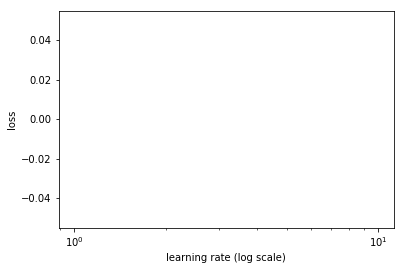

In [87]:
m.sched.plot(100)

### Sample

In [88]:
m.fit(lr, 1, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[  0.  nan  nan  nan]                                           



In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])